<a href="https://colab.research.google.com/github/KseniiaKolesnichenko/MISIS-recomendation-systems-/blob/Risk-recomendation/RNN_test_for_future_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade numpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file='8302_ver1.xlsx'

# Загрузка и предобработка данных

In [4]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import RNN, LSTM
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
torch.cuda.is_available()


False

In [6]:
%%time
#Загрузка данных

directory='drive/MyDrive/Colab Notebooks/Drilling_error_prediction/'
raw_df=pd.read_excel(directory+'Data/'+file)

CPU times: user 9.98 s, sys: 261 ms, total: 10.2 s
Wall time: 10.3 s


In [7]:
raw_df.replace(-999.25, np.nan, inplace=True)

In [8]:
#Исправление частых опечаток
raw_df.rename(columns={'Мес корость ср': 'Мех. скорость ср',
    'Мех корость ср': 'Мех. скорость ср',
    'Мех скорость ср': 'Мех. скорость ср',
    'Мех ск. средняя': 'Мех. скорость ср',
    'ЦСГО':'ЦСГО 1',
    'ЦСГО ':'ЦСГО 1',
    'Суммарная емкость': 'Сумма актив. емкостей',
                       'Сумманная емкость': 'Сумма актив. емкостей',
                       'Сумманая емкость': 'Сумма актив. емкостей',
                       'Сумма актив. ёмкостей': 'Сумма актив. емкостей',
                       'Сумма актив. ёмк.': 'Сумма актив. емкостей',
                       'Сумм. актив ёмк.': 'Сумма актив. емкостей',
                       'Сумма актив ёмк': 'Сумма актив. емкостей',
                      'Рабочаяемк. 1': 'Рабочая емк. 1',
                      'Рабочая емк.1': 'Рабочая емк. 1',
                      'Ёмк1': 'Рабочая емк. 1', 'Ёмк 1': 'Рабочая емк. 1',
                       'Рабочая ёмкость ': 'Рабочая емк. 1',
                      'Рабочаяемк. 2': 'Рабочая емк. 2',
                      'Рабочая емк.2': 'Рабочая емк. 2',
                       'Ёмк2': 'Рабочая емк. 2', 'Ёмк 2': 'Рабочая емк. 2',
                       'Рабочая ёмкость 2': 'Рабочая емк. 2',
                      'Код литологии': 'Код Литологии',
                      'код стратиграфии': 'Код стратиграфии',
                       'код горизонта маркера': 'Код горизонта маркера',
                       'Код горизонта макрера': 'Код горизонта маркера',
                      'Диаметр долота ': 'Диаметр долота',
                       'Температура вход':'Температура вх',
                       'Долив 1':'Долив',
                       'Расход вход': 'Расход на вх', 'Поток вых':'Расход на вых.',
                       'Расход ны вых.':'Расход на вых.',
                       'Вес на крюке': 'Вес на кр',
                       'Нагр на дол': 'Нагр. На долото',
                       'Обороты': 'Обороты рот',
                       'Высота крюка': 'Положение кр',
                       'Глубина долота': 'Положение долота',
                       'Плотность вход': 'Плотность на вх', 
                       'Плотность вых': 'Плотность на вых',
                      'C1':'С1', 'C2':'С2','C3':'С3','C4':'С4', 'C5':'C5',
                      'iC4':'iС4', 'iC5':'IC5', 'nC4':'С4', 'nC5':'C5',
                       'PITVOL_1':'Рабочая емк. 1', 'PITVOL_2':'Рабочая емк. 2',
                       'PITVOL_9':'Сумма актив. емкостей', 'PITVOL_3':'БПР 1',
                       'PITVOL_4':'БПР 2', 'PITVOL_5':'ЦСГО 1', 'PITVOL_6':'ЦСГО 2',
                       'PITVOL_7':'Долив','PITVOL_8':'Долив 2'
                      }, inplace=True)

In [9]:
raw_df.drop(index=0, inplace=True)
raw_df['Код осложнений'].fillna(value=0, inplace=True)

In [10]:
raw_df.head()

,Глубина,Код Литологии,С1,С2,С3,iС4,С4,IC5,C5,Вес на кр,Нагр. На долото,Давление,Момент,Обороты рот,Положение кр,Положение долота,Мех. скорость ср,Плотность на вх,Плотность на вых,Температура вх,Температура вых,Расход на вх,Расход на вых.,Рабочая емк. 1,Рабочая емк. 2,Долив,Долив 2,ЦСГО 1,ЦСГО 2,БПР 1,БПР 2,Сумма актив. емкостей,Диаметр долота,Диаметр скважины,Код осложнений,Код стратиграфии
1,11.6,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.2143,0,882.598,200,60.99,11.42,11.6,24.1667,1000,1030.2,28,25,2.0164,100,32.056,27.257,0.499,0,7.683,0.333,3.431,18.437,91.374,0.3937,0.324,0.0,20.0
2,11.7,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.6068,0,882.598,200,60.99,11.32,11.7,4.5,1000,1010,28,18,2.0164,100,32.095,26.418,0.498,0,7.953,4.605,4.056,18.439,91.533,0.3937,0.324,0.0,20.0
3,11.8,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.5444,11.4444,882.598,600,60.99,11.22,11.8,5.1667,1000,1010,28,18,1.9851,100,31.995,25.422,0.476,0,7.999,4.949,4.681,18.436,91.561,0.3937,0.324,0.0,20.0
4,11.9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.9543,18.0344,882.598,1000,60.99,11.12,11.9,6.1667,1000,1010,28,18,1.9851,100,32.062,24.078,0.503,0,7.902,5.004,5.188,18.438,91.18,0.3937,0.324,0.0,20.0
5,12,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.3749,21.6138,882.598,800,60.99,11.02,12,5,1000,1010,28,18,1.9956,100,32.074,24.012,0.484,0,7.943,5.939,5.392,18.43,91.313,0.3937,0.324,0.0,20.0


In [11]:
rows_with_NA=raw_df.isna().any(axis=1).sum()
print(f'Number of NaN values: {rows_with_NA},\
part of NaN values: {rows_with_NA/len(raw_df)*100:.2f} %\n')

Number of NaN values: 501,part of NaN values: 1.60 %



# Загрузка модели

In [12]:
#рекурентная сеть
class GRU_encoder(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size, num_layers=1):
        super().__init__()

        self.rnn = nn.GRU(input_size, hidden_size = hidden_dim, num_layers = num_layers, batch_first=True)
        #self.fc = nn.Linear(hidden_dim, output_size)
        self.out_size=output_size
    
    def forward(self, x):
        batch_size = x.size(0)
        #print(x.size())
        #Инициализация скрытого состояния
        hidden_0 = torch.zeros((self.rnn.num_layers, batch_size, self.rnn.hidden_size), device=device) 
        #cell_0 = torch.zeros((self.lstm.num_layers, batch_size, self.lstm.hidden_size), device=device)
        #print(hidden_0.size())
        # Слой LSTM
        
        rnn_out, hidden = self.rnn(x, hidden_0)
         
        #print(hidden.size())
        #Полносвязный слой
        #out = out.contiguous().view(-1, self.rnn.hidden_size)
        #out = hidden[0][-1]
        #out = F.relu(self.fc_intermediate(out))
        #out = self.fc(out)
        return rnn_out, hidden
        #return out.view(-1, self.out_size), out

class GRU_decoder(nn.Module):
    def __init__(self, input_size, hidden_dim, n_classes, n_steps_forward):
      super().__init__()

      self.rnn_cell = nn.GRUCell(input_size, hidden_size = hidden_dim)
      self.fc= nn.Linear(hidden_dim, n_classes)
      self.n_steps=n_steps_forward

    def forward(self,x, encoder_hidden_state):

      current_hidden_state=encoder_hidden_state
      #print(encoder_hidden_state.shape)
      hiddens=[]
      outs=[]
      for _ in range(self.n_steps):
        hidden = self.rnn_cell(x, current_hidden_state)
        hiddens.append(hidden)
        out=self.fc(hidden)
        outs.append(out)
      return outs, hiddens 

class GRU_seq2seq(nn.Module):
    def __init__(self, encoder, decoder, output_size):
      super().__init__()

      self.encoder=encoder
      self.decoder=decoder
      self.out_size=output_size

    def forward(self,x):
      _,encoder_hidden=self.encoder.forward(x)
      
      #print(encoder_hidden.shape)
      outputs,_=self.decoder.forward(x[:,-1],encoder_hidden[0])
      return outputs

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_file='torch.Size([666350, 50, 41])samples_accuracy_0.75598_future_pred'
model=torch.load(directory+"Code/trained_models/"+model_file+".pth",map_location=device)
model

GRU_seq2seq(
  (encoder): GRU_encoder(
    (rnn): GRU(41, 5, batch_first=True)
  )
  (decoder): GRU_decoder(
    (rnn_cell): GRUCell(41, 5)
    (fc): Linear(in_features=5, out_features=2, bias=True)
  )
)

In [14]:
order=pd.read_csv(directory+'Code/trained_models/'+model_file+'_Order_of_columns.csv', header=None)

In [15]:
print('Columns order:')
print(order[0])

Columns order:
0                   Глубина
1          Положение долота
2            Диаметр долота
3          Диаметр скважины
4                    ЦСГО 1
5                     Долив
6               Обороты рот
7     Сумма актив. емкостей
8          Мех. скорость ср
9            Рабочая емк. 1
10           Температура вх
11           Рабочая емк. 2
12                Вес на кр
13                 Давление
14             Положение кр
15          Плотность на вх
16         Плотность на вых
17          Нагр. На долото
18          Температура вых
19            Код Литологии
20         Код стратиграфии
21           Код осложнений
Name: 0, dtype: object


In [16]:
df=raw_df[order[0]]

In [17]:
rows_with_NA=df.isna().any(axis=1).sum()
print(f'Number of NaN values in cut data: {rows_with_NA},\
part of NaN values: {rows_with_NA/len(df)*100:.2f} %\n')

Number of NaN values in cut data: 81,part of NaN values: 0.26 %



In [18]:
df.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df=df.astype(np.float32, copy=False) 
df=df.astype({'Код Литологии': np.uint16,'Код осложнений': np.uint16, 'Код стратиграфии': np.uint16}
                                     , copy=False) 

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31219 entries, 1 to 31296
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Глубина                31219 non-null  float32
 1   Положение долота       31219 non-null  float32
 2   Диаметр долота         31219 non-null  float32
 3   Диаметр скважины       31219 non-null  float32
 4   ЦСГО 1                 31219 non-null  float32
 5   Долив                  31219 non-null  float32
 6   Обороты рот            31219 non-null  float32
 7   Сумма актив. емкостей  31219 non-null  float32
 8   Мех. скорость ср       31219 non-null  float32
 9   Рабочая емк. 1         31219 non-null  float32
 10  Температура вх         31219 non-null  float32
 11  Рабочая емк. 2         31219 non-null  float32
 12  Вес на кр              31219 non-null  float32
 13  Давление               31219 non-null  float32
 14  Положение кр           31219 non-null  float32
 15  Пл

In [21]:
#Масштабы
scales=pd.read_excel(directory+'Data/Масштабы.xlsx')

In [22]:
for column in df.columns:
    if not scales[column].isnull().all():
        max_value = scales[column].loc[2]
        min_value = scales[column].loc[1]
        df[column] = (df[column] - min_value) / (max_value - min_value)

In [23]:
min_depth=scales['Глубина'].loc[1]
max_depth=scales['Глубина'].loc[2]

In [24]:
df.head()

,Глубина,Положение долота,Диаметр долота,Диаметр скважины,ЦСГО 1,Долив,Обороты рот,Сумма актив. емкостей,Мех. скорость ср,Рабочая емк. 1,Температура вх,Рабочая емк. 2,Вес на кр,Давление,Положение кр,Плотность на вх,Плотность на вых,Нагр. На долото,Температура вых,Код Литологии,Код стратиграфии,Код осложнений
1,0.00116,0.331429,0.000787,0.000648,0.15366,0.00998,0.6099,0.261069,0.096667,0.64112,0.28,0.54514,0.201429,3.530394,0.326286,333.333344,343.399994,0.000000,0.25,10,20,0
2,0.00117,0.334286,0.000787,0.000648,0.15906,0.00996,0.6099,0.261523,0.018000,0.64190,0.28,0.52836,0.210712,3.530394,0.323429,333.333344,336.666656,0.000000,0.18,10,20,0
3,0.00118,0.337143,0.000787,0.000648,0.15998,0.00952,0.6099,0.261603,0.020667,0.63990,0.28,0.50844,0.123629,3.530394,0.320571,333.333344,336.666656,0.076296,0.18,10,20,0
4,0.00119,0.340000,0.000787,0.000648,0.15804,0.01006,0.6099,0.260514,0.024667,0.64124,0.28,0.48156,0.079695,3.530394,0.317714,333.333344,336.666656,0.120229,0.18,10,20,0
5,0.00120,0.342857,0.000787,0.000648,0.15886,0.00968,0.6099,0.260894,0.020000,0.64148,0.28,0.48024,0.055833,3.530394,0.314857,333.333344,336.666656,0.144092,0.18,10,20,0


# Формирование датасета из данных

In [25]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [26]:
#Коды литологии и стратиграфии
litology_code=pd.read_csv(directory+'Data/Литология_коды.csv', header=1, delimiter=';', usecols=[0,1])
stratigraphy_code=pd.read_csv(directory+'Data/Стратиграфия_коды.csv', header=1, delimiter=';', usecols=[0,1])

In [27]:
#В файлах встречаются коды литологии 12, 16, 113
#Встречаются стратиграфии 30
lit_codes=np.sort(np.hstack([litology_code['Код литологии'].values,12,16,113, 64537]))
print(f"Количество литологий: {len(lit_codes)}")
strat_codes=np.sort(np.hstack([stratigraphy_code['Код стратиграфии'].values])).reshape(1,-1)
print(f"Количество стратиграфий: {len(strat_codes[0])}")

Количество литологий: 20
Количество стратиграфий: 22


In [28]:
encoder_lit = OneHotEncoder(categories=lit_codes.reshape(1,-1))
encoder_strat = OneHotEncoder(categories=strat_codes)
label_encoder=LabelEncoder()

In [29]:
#Если нужно, то заменяем некоторые коды литологии и стратиграфии
df.replace({"Код стратиграфии": {30: 31}}, inplace=True)

In [30]:
%%capture --no-stdout
#Перевод всех данных в двумерный массив и one-hot encoding для столбцов 
#кодов литологии и кодов стратиграфии

X=df.drop(columns=['Код Литологии', 'Код осложнений', 'Код стратиграфии']).values
#Y=df['Код осложнений'].values
Y=(df['Код осложнений'].values>0).astype(int)
encoded_X_lit=encoder_lit.fit_transform(df['Код Литологии'].values.reshape(-1,1)).toarray()
encoded_X_strat=encoder_strat.fit_transform(df['Код стратиграфии'].values.reshape(-1,1)).toarray()
#total_X= np.hstack([X, encoded_X_lit, encoded_X_strat])
total_X=np.hstack([X, encoded_X_strat])
total_Y=Y

In [31]:
total_X.shape

(31219, 41)

In [32]:
%%capture --no-stdout
#Объединение данных в группы по number_of_depth_points точек
number_of_depth_points=50
n_steps_forward=10
    
X_grouped=np.lib.stride_tricks.sliding_window_view(total_X,(number_of_depth_points,total_X.shape[1]))[:-n_steps_forward,0]
    
Y_grouped=np.lib.stride_tricks.sliding_window_view(Y[number_of_depth_points:],(n_steps_forward,))

print(X_grouped.shape)
print(Y_grouped.shape)

(31160, 50, 41)
(31160, 10)


# Тест модели

In [33]:
%%time
outputs = model(torch.Tensor(X_grouped))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  """Entry point for launching an IPython kernel.


CPU times: user 1.08 s, sys: 1.3 s, total: 2.37 s
Wall time: 2.52 s


In [34]:
n_outputs = model.decoder.n_steps
correct_answers = np.zeros(n_outputs)
correctly_predicted_errors = np.zeros(n_outputs)
total_samples=np.zeros(n_outputs)
total_errors=np.zeros(n_outputs)
    
with torch.no_grad():
    labels = torch.Tensor(Y_grouped)
    for ind, output in enumerate(outputs):
      label=labels[:,ind]
      _, predicted = torch.max(output.data, 1)
      #print(labels>0)
      correct_answers[ind]=correct_answers[ind]+(predicted == label).sum().item()
      correctly_predicted_errors[ind]=correctly_predicted_errors[ind]+((predicted == label) & (label>0)).sum().item()
      total_samples[ind]=total_samples[ind]+len(label)
      total_errors[ind]=total_errors[ind] + len(label[label>0])
error_acc = correctly_predicted_errors/total_errors
acc = correct_answers/total_samples

In [35]:
print(f"Test accuracy: {acc}, test error accuracy: {error_acc}")
print(f"Total errors in test dataset: {total_errors}")

Test accuracy: [0.98761232 0.98761232 0.98761232 0.98761232 0.98761232 0.98761232
 0.98761232 0.98761232 0.98761232 0.98761232], test error accuracy: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Total errors in test dataset: [386. 386. 386. 386. 386. 386. 386. 386. 386. 386.]


In [36]:
arr=np.where(Y_grouped==0, "Нет осложнения", "Осложнение")

# Визуализация предсказания

In [37]:
save_fig=True
step_number=2

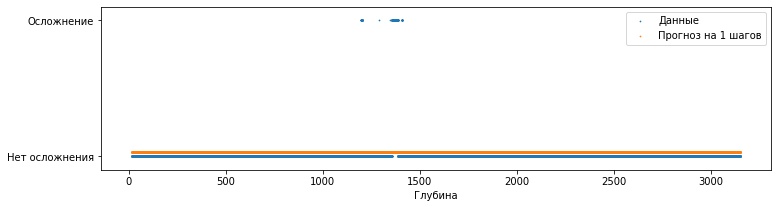

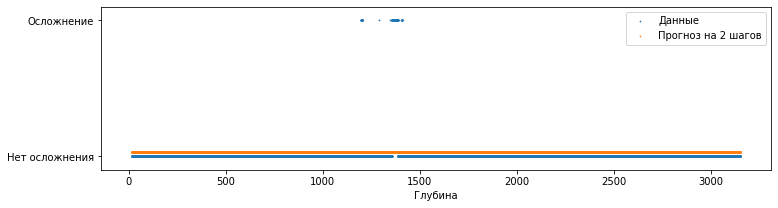

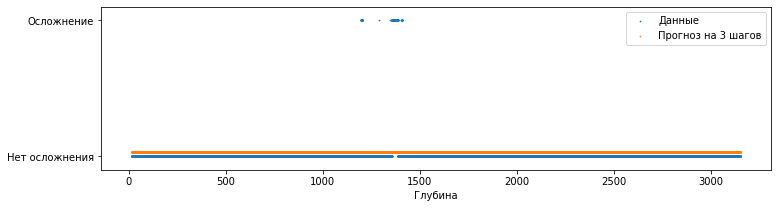

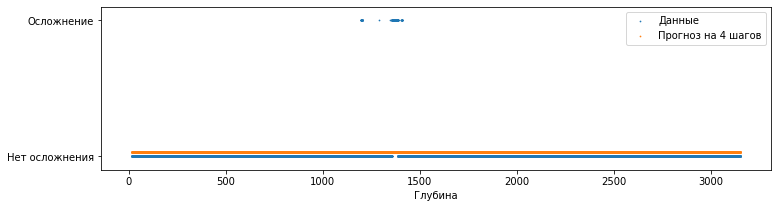

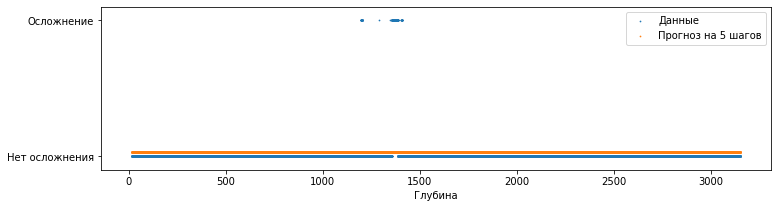

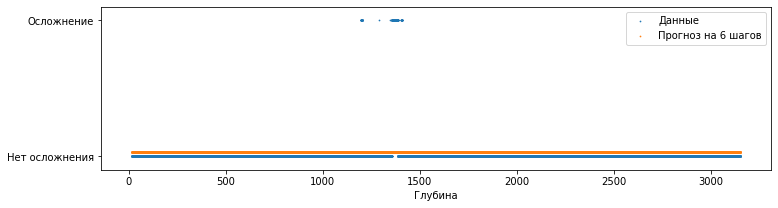

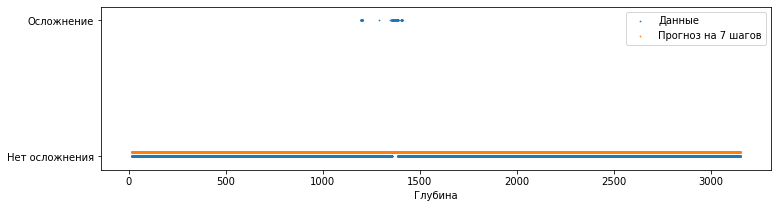

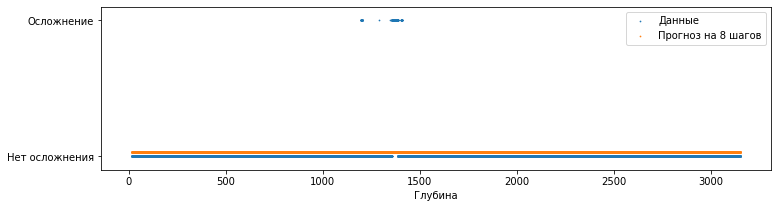

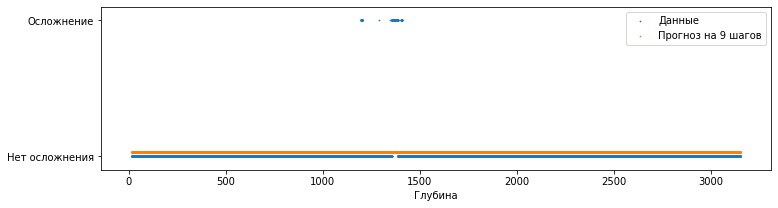

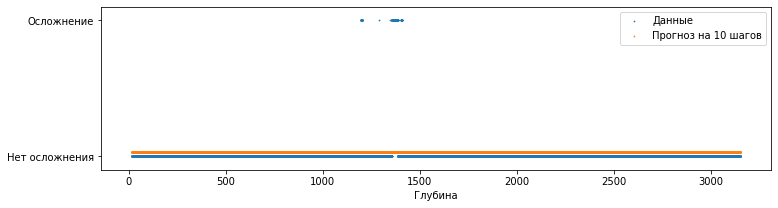

In [38]:
for ind_out, output in enumerate(outputs):
  plt.figure(figsize=(12,3))
  arr=np.where(labels[:,ind_out]==0, "Нет осложнения", "Осложнение")
  plt.scatter(X_grouped[:,-1,0]*max_depth,arr, s=0.5, label='Данные')
  #label=labels[:,ind_out]
  _, predicted = torch.max(output.data, 1)
  pred = predicted.cpu()
      
  plt.scatter(X_grouped[:,-1,0]*max_depth,pred+0.03, s=0.5, label=f'Прогноз на {ind_out+1} шагов')   
  plt.xlabel('Глубина')
    
  plt.legend()
  plt.ylim(top=1.1, bottom=-0.1)
  if (save_fig and ind_out==step_number-1):
    fig_file=file.split('.')[0]
    plt.savefig(directory+'Data/Prediction_vis/'+ fig_file+'_future.png',dpi=600, facecolor='white', bbox_inches='tight')
  
  plt.show()